In [2]:
import pickle
# ! pip install --user scikit-misc
import warnings
from datetime import datetime

import xgboost as xgb
from matplotlib.pyplot import title
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', )
warnings.simplefilter(action='ignore', )
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import maxfuse as mf
import anndata
import hdbscan
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, f1_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread
from scipy import sparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_rows', 10)  # Display only 10 rows
pd.set_option('display.max_columns', 5)  # Display only 5 columns

# setup and load datasets (only run once)
## CODEX

In [3]:
codex = sc.read(filename="/home/barroz/projects/Columbia/STAT_ML_GEN/project/codex_codex_cn_tumor.h5ad")
sc.pp.subsample(codex, fraction=0.01)
rna = sc.read(filename="/home/barroz/projects/Columbia/STAT_ML_GEN/project/scRNA-seq_rna_umap.h5ad")
sc.pp.subsample(rna, fraction=0.1)


In [4]:
adata_obs = codex  #sc.read_h5ad('codex.h5ad').obs
adata_obs = codex.obs

adata_obs.head()

,orig.ident,nCount_CODEX,...,condition,neighborhood
2849878,Longitudinal_Analysis,18291.1948,...,ICT,3
567160,Longitudinal_Analysis,16414.7984,...,CONTROL,2
473497,Longitudinal_Analysis,22362.7807,...,CONTROL,4
663789,Longitudinal_Analysis,11978.5676,...,CONTROL,7
2094541,Longitudinal_Analysis,22377.1193,...,ICT,4


In [5]:
# map neighborhood information (indices should match)
codex.obs['CN'] = adata_obs['neighborhood']

In [6]:
# FIX THIS
codex.obs['CN'] = codex.obs['CN'].replace({
    1: 'CN1 Tumor Boundary',
    2: 'CN2 Tumor Bulk',
    3: 'CN3 Neutrophils + Dead cells',
    4: 'CN4 CX3CR1+ Macrophage',
    5: 'CN5 Dead Cells Center',
    6: 'CN6 Lymphoid Rich',
    7: 'CN7 INOS+ and IFN-g Actv Macs',
}).astype('category')

In [7]:
rna.var['mf_features'] = \
sc.pp.highly_variable_genes(rna, n_top_genes=2000, batch_key=None, flavor='seurat_v3', layer='counts', inplace=False)[
    'highly_variable']

In [8]:
sc.tl.rank_genes_groups(rna, groupby='new_annotation', method='t-test')


In [9]:
print(np.sum(rna.var['mf_features']))
for ct in rna.obs['new_annotation'].unique():
    degs = sc.get.rank_genes_groups_df(rna, group=ct).iloc[:100, 0].values
    rna.var.loc[rna.var.index.isin(degs), 'mf_features'] = True
print(np.sum(rna.var['mf_features']))

2000
2307


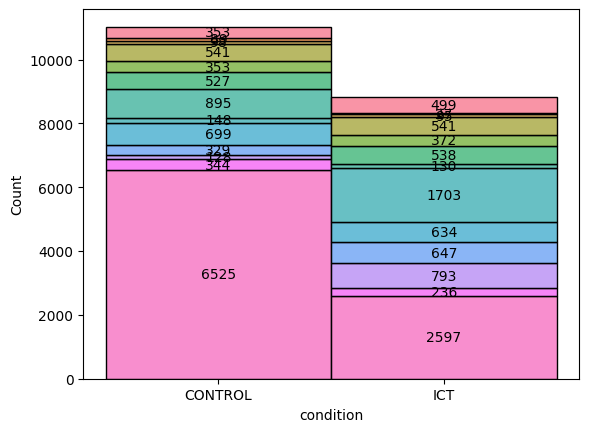

In [10]:
ax = sns.histplot(codex.obs, x='condition', hue='cell_type', multiple='stack', legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center')

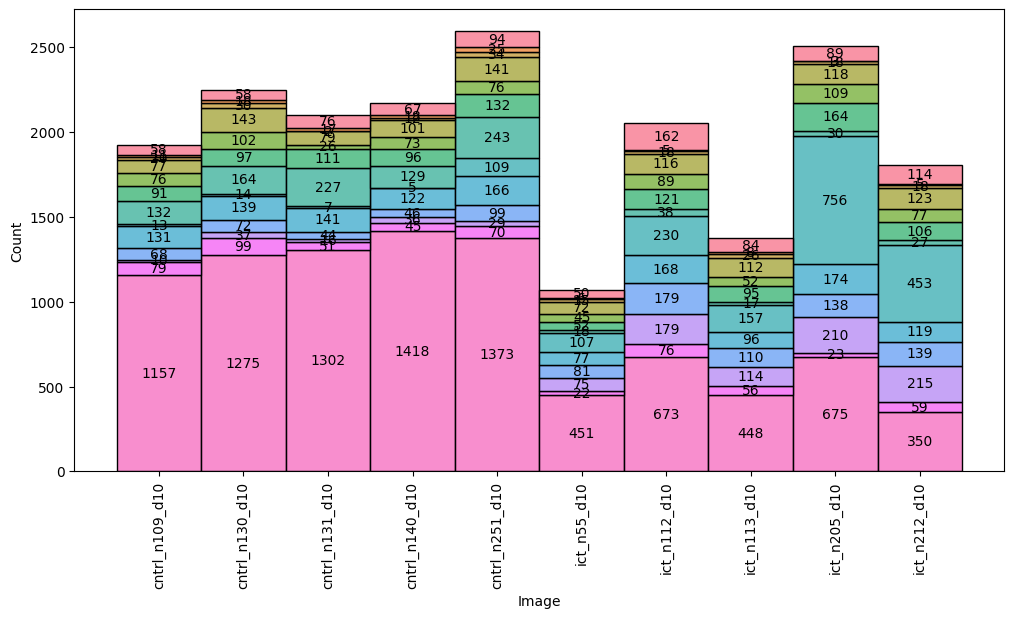

In [11]:
plt.subplots(figsize=(12, 6))
ax = sns.histplot(codex.obs, x='Image', hue='cell_type', multiple='stack', legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.xticks(rotation=90);

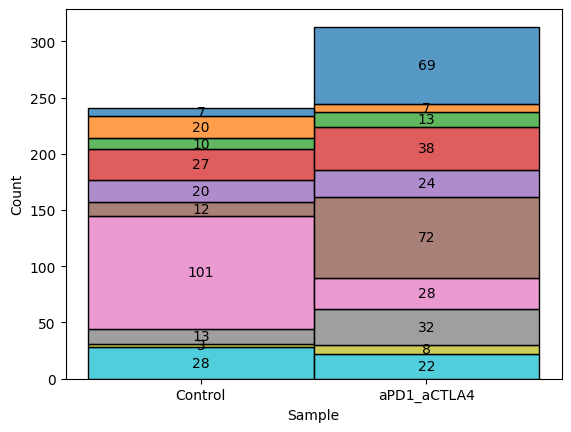

In [12]:
ax = sns.histplot(rna.obs, x='Sample', hue='new_annotation', multiple='stack', legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center')

In [13]:
# from maxfuse repo
conversion = pd.read_csv('data/protein_gene_conversion.csv', index_col=0)


In [14]:
h_m_map = pd.read_csv('data/human2mouse.txt', sep='\t', index_col=0)
h_m_map.reset_index(inplace=True)

In [15]:
found_rna = []
not_found = []
for gene in codex.var_names:
    if gene.capitalize() in rna.var_names:
        found_rna.append(gene.capitalize())
    else:
        not_found.append(gene.capitalize())

In [16]:

found_h_m_map = []
for i, gene in enumerate(not_found):
    if gene.capitalize() in h_m_map['Mouse'].values:
        found_h_m_map.append(gene.capitalize())
        not_found.pop(i)

In [17]:
found_protein_conversion = []
for i, gene in enumerate(not_found):
    if gene in conversion.index.values:
        found_protein_conversion.append(gene + ':' + conversion.loc[gene, 'RNA name'])
        not_found.pop(i)

In [18]:
found_protein_conversion2 = []
for i, gene in enumerate(not_found):
    if gene.upper() in conversion.index.values:
        found_protein_conversion2.append(gene + ':' + conversion.loc[gene.upper(), 'RNA name'])
        not_found.pop(i)

In [19]:
print('found in rna:', found_rna)
print('needs human mapping:', found_h_m_map)
print('found_protein_conversion', found_protein_conversion)
print('found_protein_conversion2', found_protein_conversion2)
print(not_found)

found in rna: ['Foxp3', 'Cx3cr1', 'Xcr1', 'Gzmb', 'Cd4', 'Lag3', 'Cd38', 'Ly6g']
needs human mapping: []
found_protein_conversion ['Ki67:MKI67', 'Cd90:THY1']
found_protein_conversion2 ['Cd103:ITGAE', 'Cd3:CD3E/CD3D/CD3G', 'Pd1:PDCD1', 'Cd45:PTPRC/PTPRCAP', 'Cd31:PECAM1', 'Cd24:CD24', 'Pdl1:CD274']
['Cd140', 'Cd8', 'Nkp46', 'Tim 3', 'Sirp-alpha', 'Cd206', 'Caspase 3', 'Cd64', 'F4-80', 'Cd11c', 'Inos', 'Cd11b', 'Mhcii']


In [20]:
protein_mapping = {
    'cd103': 'Itgae',
    'ki67': 'Mki67',
    'foxp3': 'Foxp3',
    'cd140': 'Pdgfra',  # CD140 protein same as PDGFRA gene? 
    'cx3cr1': 'Cx3cr1',
    'cd3': 'Cd3d',  # or Cd3e or Cd3g 
    'cd8': 'Cd8b1',  # or Cd8a
    'nkp46': 'Ncr1',  # NKP46 protein same as NCR1 gene?
    'tim 3': 'Havcr2',  # TIM3 protein same as HAVCR2 gene?  
    'xcr1': 'Xcr1',
    'sirp-alpha': 'Sirpa',
    'gzmB': 'Gzmb',
    'pd1': 'Pdcd1',
    'cd206': 'Mrc1',
    'cd4': 'Cd4',
    'caspase 3': 'Casp3',
    'cd45': 'Ptprc',  # or Ptprcap
    'Lag3': 'Lag3',
    'cd64': 'Fcgr1',
    'f4-80': 'Adgre1',
    'cd38': 'Cd38',
    'cd31': 'Pecam1',
    'cd11c': 'Itgax',
    'cd24': 'Cd24a',
    'inos': 'Nos2',
    'cd11b': 'Itgam',
    'ly6G': 'Ly6g',
    'cd90': 'Thy1',
    'mhcii': None,
    # composed of HLA-DPA1, HLA-DPB1, HLA-DQA1, HLA-DQB1, HLA-DRA? # not including because biased towards treated condition in scRNA, vs. codex
    'pdL1': 'Cd274',
}

In [21]:
print(sorted(list(rna.var[rna.var_names.str.contains('H2')].index))[8:])

['H2-Aa', 'H2-Ab1', 'H2-D1', 'H2-DMa', 'H2-DMb1', 'H2-DMb2', 'H2-Eb1', 'H2-Eb2', 'H2-K1', 'H2-Ke6', 'H2-M2', 'H2-M3', 'H2-Oa', 'H2-Ob', 'H2-Q1', 'H2-Q10', 'H2-Q4', 'H2-Q6', 'H2-Q7', 'H2-T22', 'H2-T23', 'H2-T24', 'H2-T3', 'H2afj', 'H2afv', 'H2afx', 'H2afy', 'H2afy2', 'H2afz']


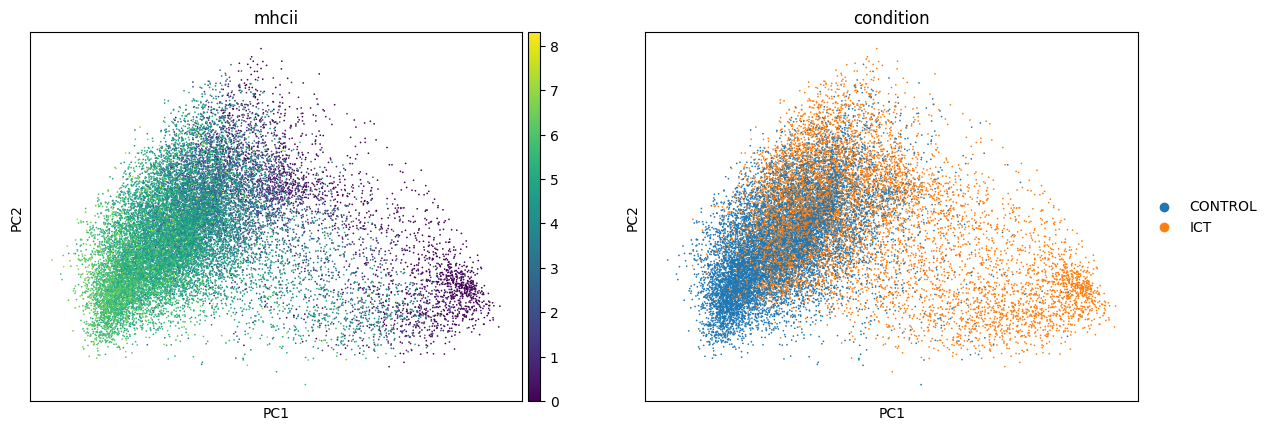

In [22]:
# run pca
sc.pp.pca(codex)
sc.pl.pca(codex, color=['mhcii', 'condition'])


In [23]:
protein_index = list()
RNA_index = list()
for protein in protein_mapping.keys():
    if protein_mapping[protein] != None:
        protein_index.append(protein)
        RNA_index.append(protein_mapping[protein])
print(protein_index)
print(RNA_index)

['cd103', 'ki67', 'foxp3', 'cd140', 'cx3cr1', 'cd3', 'cd8', 'nkp46', 'tim 3', 'xcr1', 'sirp-alpha', 'gzmB', 'pd1', 'cd206', 'cd4', 'caspase 3', 'cd45', 'Lag3', 'cd64', 'f4-80', 'cd38', 'cd31', 'cd11c', 'cd24', 'inos', 'cd11b', 'ly6G', 'cd90', 'pdL1']
['Itgae', 'Mki67', 'Foxp3', 'Pdgfra', 'Cx3cr1', 'Cd3d', 'Cd8b1', 'Ncr1', 'Havcr2', 'Xcr1', 'Sirpa', 'Gzmb', 'Pdcd1', 'Mrc1', 'Cd4', 'Casp3', 'Ptprc', 'Lag3', 'Fcgr1', 'Adgre1', 'Cd38', 'Pecam1', 'Itgax', 'Cd24a', 'Nos2', 'Itgam', 'Ly6g', 'Thy1', 'Cd274']


In [24]:
rna_shared = rna[:, RNA_index].copy()
codex_shared = codex[:, protein_index].copy()
print(rna_shared.shape)
print(codex_shared.shape)

(554, 29)
(19841, 29)


In [25]:
protein_index = list()
RNA_index = list()
for protein in protein_mapping.keys():
    if protein_mapping[protein] != None:
        protein_index.append(protein)
        RNA_index.append(protein_mapping[protein])
print(protein_index[:5], '...')
print(RNA_index[:5], '...')

['cd103', 'ki67', 'foxp3', 'cd140', 'cx3cr1'] ...
['Itgae', 'Mki67', 'Foxp3', 'Pdgfra', 'Cx3cr1'] ...


In [26]:
# only 18 of the ~30 shared features are HVGs in scRNA-seq
rna_shared = rna[:, RNA_index].copy()
codex_shared = codex[:, protein_index].copy()
print(rna_shared.shape)
print(codex_shared.shape)
np.sum(rna_shared.var['mf_features'])


(554, 29)
(19841, 29)


22

In [27]:
rna.var.loc[RNA_index, 'mf_features'] = True
rna_shared.var.loc[RNA_index, 'mf_features'] = True
print(np.sum(rna.var['mf_features']))

2314


In [28]:
sc.pp.neighbors(rna_shared, n_neighbors=15, use_rep='X')
sc.tl.umap(rna_shared)

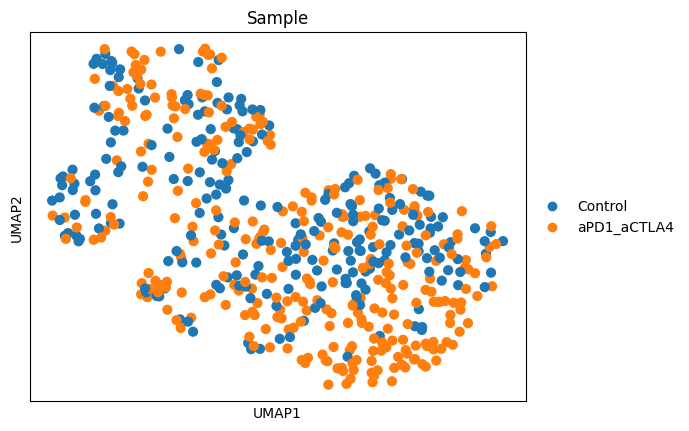

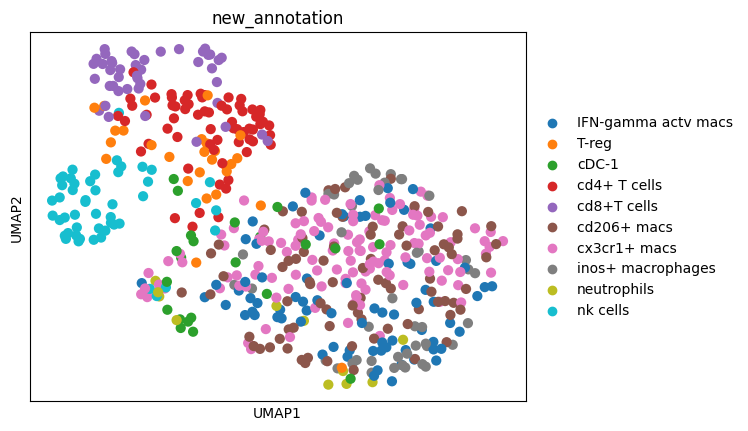

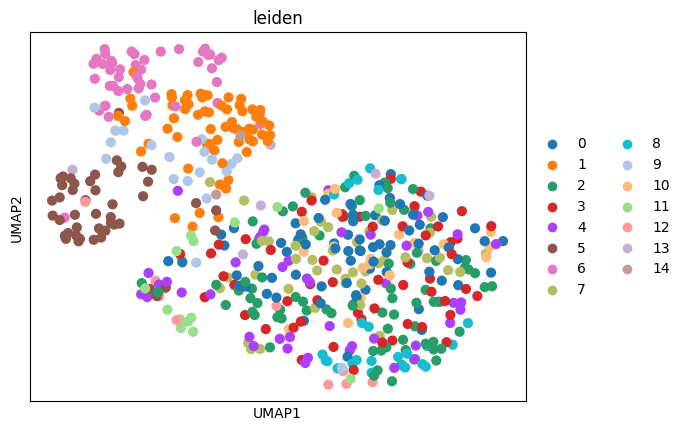

In [29]:
sc.pl.umap(rna_shared, color=['Sample'])
sc.pl.umap(rna_shared, color=['new_annotation'])
sc.pl.umap(rna_shared, color=['leiden'])

In [30]:
rna_shared = rna_shared.X.copy()
codex_shared = codex_shared.X.copy()

In [31]:
rna_active = rna[:, rna.var['mf_features']].copy()
sc.pp.scale(rna_active)  # preprocessing in the tutorial, makes it mean=0 and std var
rna_active = rna_active.X

In [32]:
codex_active = codex.copy()
# not sure if needed to scale protein measurements (they don't do it in tutorial, but the scale might be [0,1] based on methods section)
codex_active = codex.X

In [33]:
rna_active = np.asarray(rna_active)  # already dense numpy array
codex_active = np.asarray(codex_active.todense())
rna_shared = np.asarray(rna_shared.todense())
codex_shared = np.asarray(codex_shared.todense())

print(rna_active.shape)
print(codex_active.shape)
print(rna_shared.shape)
print(codex_shared.shape)

(554, 2314)
(19841, 30)
(554, 29)
(19841, 29)


# Fix MaxFuse

In [34]:
# use cell labels to guide MaxFuse smoothing steps
labels_rna = rna.obs['new_annotation'].values
labels_codex = codex.obs['cell_type'].values

display(labels_rna)
display(labels_codex)

['IFN-gamma actv macs', 'nk cells', 'cd4+ T cells', 'T-reg', 'neutrophils', ..., 'cd8+T cells', 'IFN-gamma actv macs', 'cx3cr1+ macs', 'cd206+ macs', 'IFN-gamma actv macs']
Length: 554
Categories (10, object): ['IFN-gamma actv macs', 'T-reg', 'cDC-1', 'cd4+ T cells', ..., 'cx3cr1+ macs', 'inos+ macrophages', 'neutrophils', 'nk cells']

['neutrophils', 'IFN-gamma actv macs', 'tumor', 'cx3cr1+ macs', 'inos+ macrophages', ..., 'tumor', 'endothelial cells', 'inos+ macrophages', 'cd8+T cells', 'cd8+T cells']
Length: 19841
Categories (13, object): ['IFN-gamma actv macs', 'T-reg', 'cDC-1', 'cd4+ T cells', ..., 'inos+ macrophages', 'neutrophils', 'nk cells', 'tumor']

In [35]:
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    active_arr1=rna_active,
    labels1=labels_rna,
    shared_arr2=codex_shared,
    active_arr2=codex_active,
    labels2=labels_codex,
)

In [36]:
# see tutorial for explanation -- the below reduces computational complexity
fusor.split_into_batches(
    max_outward_size=8000,
    matching_ratio=4,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 554, and max batch size is 554.
The second data is split into 1 batches, average batch size is 19841, and max batch size is 19841.
Batch to batch correspondence is:
  ['0<->0'].


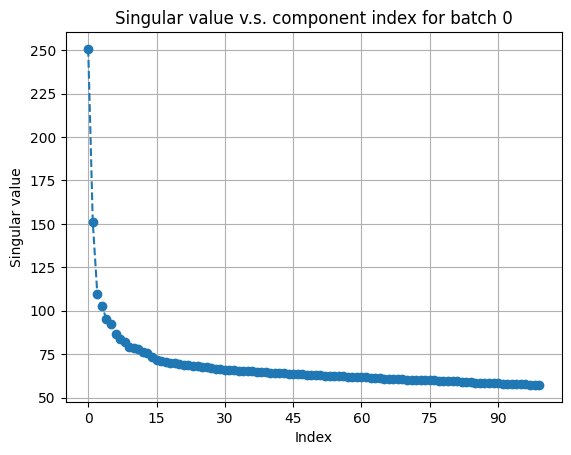

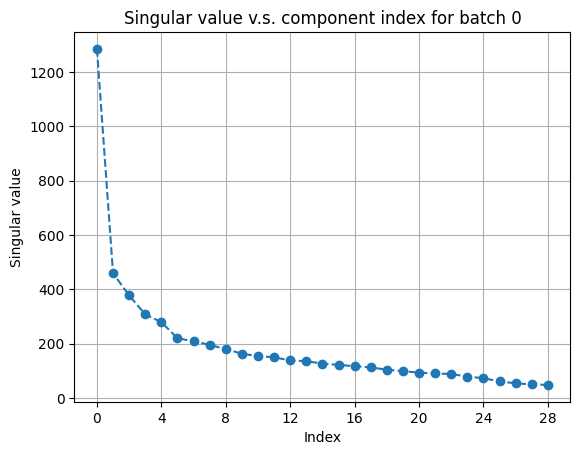

In [37]:
# plot top singular values of active_arr1 on a random batch
fusor.plot_singular_values(target='active_arr1',
                           n_components=None);  # can also explicitly specify the number of components
# plot top singular values of active_arr2 on a random batch
fusor.plot_singular_values(target='active_arr2', n_components=None);

In [38]:
svd_components1 = 40
svd_components2 = 15

fusor.construct_graphs(
    n_neighbors1=2,
    n_neighbors2=2,
    svd_components1=svd_components1,
    svd_components2=svd_components2,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!


In [39]:
svd_components1 = 20
svd_components2 = 20

fusor.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    # weights of first and second modality; smaller = greater strength of fuzzy smoothing, 1 = original data used
    svd_components1=svd_components1, svd_components2=svd_components2)

Now at batch 0<->0...
Done!


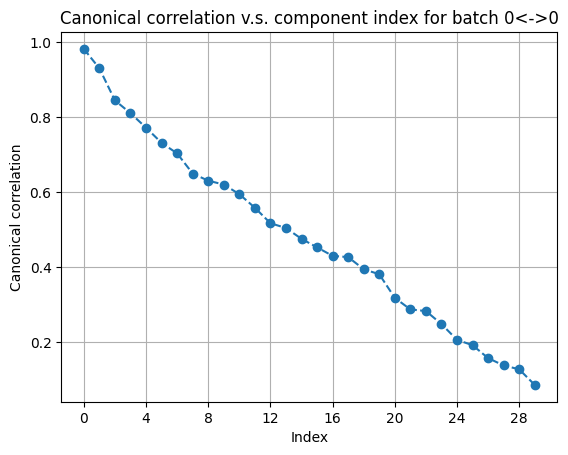

In [40]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=40,
    svd_components2=None,
    cca_components=30
);

In [41]:
fusor.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=None,
    cca_components=25,
    n_iters=1,
    randomized_svd=False,
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Done!


In [42]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.5)  # 50% recommended by tutorial for spatial data

Begin filtering...
Now at batch 0<->0...
119/237 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
283/554 cells in arr1 are selected as pivots.
119/19841 cells in arr2 are selected as pivots.
Done!


In [43]:
# check performance based on cell type accuracy (pivot matching)
pivot_matching = fusor.get_matching(order=(2, 1), target='pivot')

lv1_acc = mf.metrics.get_matching_acc(matching=pivot_matching,
                                      labels1=labels_rna,
                                      labels2=labels_codex,
                                      order=(2, 1)
                                      )
lv1_acc

0.7563025210084033

In [44]:
fusor.propagate(
    svd_components1=40,
    svd_components2=None,
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Done!


In [45]:
fusor.filter_bad_matches(target='propagated', filter_prop=0.3)  # recommended filter_prop between 0.1 - 0.4

Begin filtering...
Now at batch 0<->0...
13888/19840 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [46]:
# with open(f'fusor_object_{datetime.now().strftime("%Y-%m-%d_%H%M")}.pkl', 'wb') as f:
#     pickle.dump(fusor, f)

In [47]:
full_matching = fusor.get_matching(order=(2, 1),
                                   target='full_data')  # we want rna (1) to match with multiple codex (2), not other way around

In [48]:
pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])),
             columns=['mod1_indx', 'mod2_indx', 'score'])
# columns: cell idx in mod1, cell idx in mod2, and matching scores

,mod1_indx,mod2_indx,score
0,470,22,0.664984
1,392,95,0.715691
2,431,120,0.749459
3,380,193,0.648301
4,444,203,0.674582
...,...,...,...
14001,129,19835,0.270746
14002,120,19836,0.406212
14003,236,19838,0.586794
14004,330,19839,0.322782


In [49]:
# compute the cell type level matching accuracy, for the full (filtered version) dataset
lv1_acc = mf.metrics.get_matching_acc(matching=full_matching,
                                      labels1=labels_rna,
                                      labels2=labels_codex
                                      )
lv1_acc

0.20669712980151364

In [50]:
# cm = confusion_matrix(labels_rna[pivot_matching[0]], labels_codex[pivot_matching[1]])
# ConfusionMatrixDisplay(
#     confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
#     display_labels=np.unique(labels_rna),
# ).plot()

EOFError: Ran out of input

In [66]:

rna_embedding, codex_embedding = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2
)
codex.obsm['X_maxfuse'] = codex_embedding

codex_embedding = anndata.AnnData(codex_embedding)
codex_embedding.obs = codex.obs
rna_embedding = anndata.AnnData(rna_embedding)
rna_embedding.obs = rna.obs
codex_embedding.write('codex_embedding.h5ad')
rna_embedding.write('rna_embedding.h5ad')


EOFError: Ran out of input

rna_embedding size: (554, 25)
codex_embedding size: (19841, 25)


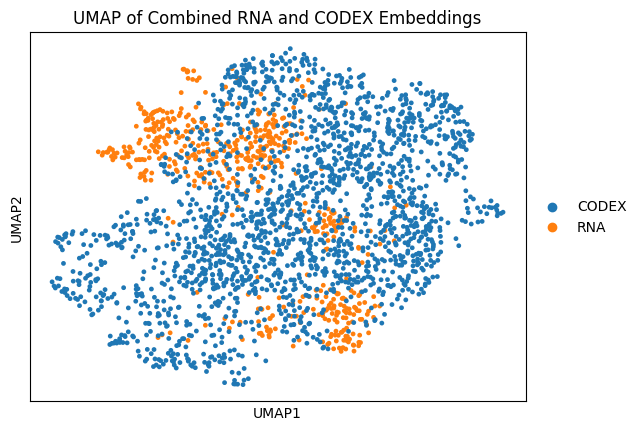

In [63]:
# Print sizes of rna_embedding and codex_embedding
print(f'rna_embedding size: {rna_embedding.shape}')
print(f'codex_embedding size: {codex_embedding.shape}')
# taks only 10% of the protein data
sc.pp.subsample(codex_embedding, fraction=0.1)

# Combine RNA and CODEX embeddings into a single AnnData object
combined_embedding = ad.AnnData(
    np.concatenate((rna_embedding.X, codex_embedding.X)),
    obs=pd.concat([rna_embedding.obs, codex_embedding.obs])
)

# Add a column to indicate the source (RNA or CODEX)
combined_embedding.obs['source'] = ['RNA'] * rna_embedding.shape[0] + ['CODEX'] * codex_embedding.shape[0]

# Perform UMAP on the combined data
sc.pp.neighbors(combined_embedding, n_neighbors=15)
sc.tl.umap(combined_embedding)

# Plot the UMAP with the source as color
sc.pl.umap(combined_embedding, color='source', title='UMAP of Combined RNA and CODEX Embeddings')

In [71]:
rna_cells

AnnData object with n_obs × n_vars = 554 × 25
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tSNE_1', 'tSNE_2', 'Sample', 'Cluster', 'nUmi', 'nGene', 'nUmiLog2', 'nGeneLog2', 'new_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden', 'nCount_CODEX', 'nFeature_CODEX', 'cell_id', 'Image', 'x_um', 'y_um', 'cell_type', 'day', 'condition', 'neighborhood', 'CN', 'source'
    uns: 'neighbors', 'umap', 'source_colors', 'cell_type_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

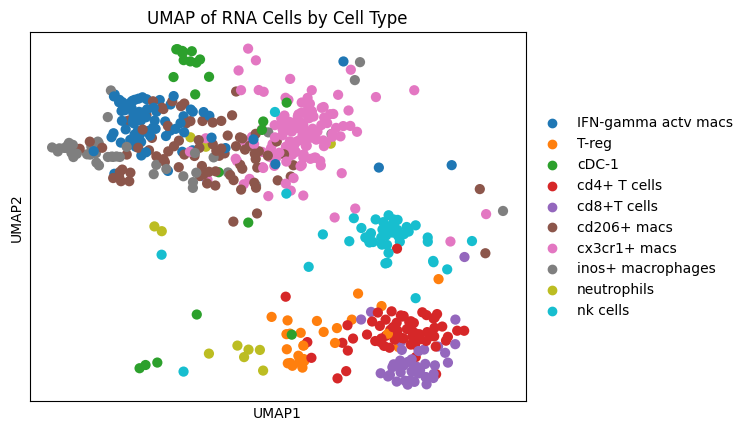

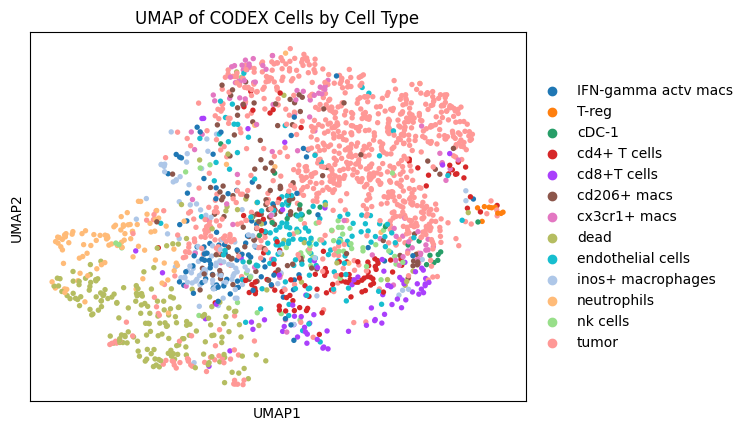

In [73]:
# Subset the combined embedding for RNA and CODEX cells
rna_cells = combined_embedding[combined_embedding.obs['source'] == 'RNA']
codex_cells = combined_embedding[combined_embedding.obs['source'] == 'CODEX']

# Plot the UMAP for RNA cells
sc.pl.umap(rna_cells, color='new_annotation', title='UMAP of RNA Cells by Cell Type')

# Plot the UMAP for CODEX cells
sc.pl.umap(codex_cells, color='cell_type', title='UMAP of CODEX Cells by Cell Type')


In [ ]:
# Print sizes of rna_embedding and codex_embedding
print(f'rna_embedding size: {rna_embedding.shape}')
print(f'codex_embedding size: {codex_embedding.shape}')

# Combine RNA and CODEX embeddings into a single AnnData object
combined_embedding = ad.AnnData(
    np.concatenate((rna_embedding.X, codex_embedding.X)),
    obs=pd.concat([rna_embedding.obs, codex_embedding.obs])
)

# Add a column to indicate the source (RNA or CODEX)
combined_embedding.obs['source'] = ['RNA'] * rna_embedding.shape[0] + ['CODEX'] * codex_embedding.shape[0]

# Perform UMAP on the combined data
sc.pp.neighbors(combined_embedding, n_neighbors=15)
sc.tl.umap(combined_embedding)

# Plot the UMAP with the source as color
sc.pl.umap(combined_embedding, color='source', title='UMAP of Combined RNA and CODEX Embeddings')

In [61]:
# num rna cell vs num codex cell
codex_embedding = anndata.read('codex_embedding.h5ad')
rna_embedding = anndata.read('rna_embedding.h5ad')
print(rna_embedding.shape)
print(codex_embedding.shape)


(554, 25)
(19841, 25)


In [53]:

# Create an AnnData object combining RNA and CODEX cells in the shared space
rna_labels = ['RNA'] * rna_embedding.X.shape[0]
codex_labels = ['CODEX'] * codex_embedding.X.shape[0]
data_type_labels = np.concatenate([rna_labels, codex_labels])

combined_data = ad.AnnData(
    np.concatenate((rna_embedding.X, codex_embedding.X)),
    obs=pd.concat([rna.obs, codex.obs])
)
combined_data.obs['data_type'] = data_type_labels

# Perform UMAP on the combined data
# sc.pp.neighbors(combined_data, n_neighbors=15)
sc.tl.pca(combined_data)

# Plot the co-embedding
sample_fraction = 0.1
n_cells = combined_data.shape[0]
random_indices = np.random.choice(n_cells, size=int(n_cells * sample_fraction), replace=False)

# Subset the AnnData object to only include the sampled cells
sampled_data = combined_data[random_indices, :]
# sc.pl.pca(sampled_data, color=['Cluster', 'data_type'])



# Train a classifier on the co-embedding

In [54]:
import copy

# prepare data for training
features = codex_embedding.X
labels = codex_embedding.obs['CN']
labels = copy.deepcopy(labels.astype('category').values.codes)
labels

array([2, 1, 3, ..., 5, 0, 5], dtype=int8)

In [55]:
# make small subset for testing
# features = features[:100]
# labels = labels[:100]
# # labels[:50] =1
# labels[50:]=0
# labels

In [56]:

random_state = 42

X = pd.DataFrame(features)
y = pd.DataFrame(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='weighted')
print(f'f1 score: {score:.4f}')

f1 score: 0.6178


In [57]:
from sklearn.decomposition import PCA


In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    BaggingClassifier
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import xgboost as xgb
X = pd.DataFrame(features)
y = pd.DataFrame(labels)
y = y.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=random_state),
    'Random Forest': RandomForestClassifier(random_state=random_state),
    'Extra Trees': ExtraTreesClassifier(random_state=random_state),
    'AdaBoost': AdaBoostClassifier(random_state=random_state),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
    'Support Vector Machine': SVC(random_state=random_state, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Stochastic Gradient Descent': SGDClassifier(random_state=random_state),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=random_state),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state),
}

f1_scores = {}

for name, model in models.items():
    print(f'Training {name}...')
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='weighted')
        f1_scores[name] = score
        print(f'{name} F1 Score: {score:.4f}')
    except Exception as e:
        print(f'{name} could not be trained. Error: {e}\n')

# Display the F1 scores
print('\nModel Performance Comparison:')
for name, score in f1_scores.items():
    print(f'{name}: F1 Score = {score:.4f}')


Training Decision Tree...
Decision Tree F1 Score: 0.4663
Training Random Forest...
Random Forest F1 Score: 0.5939
Training Extra Trees...
Extra Trees F1 Score: 0.5897
Training AdaBoost...
AdaBoost F1 Score: 0.5303
Training Gradient Boosting...


KeyboardInterrupt: 

In [63]:

original_f1_scores = f1_scores


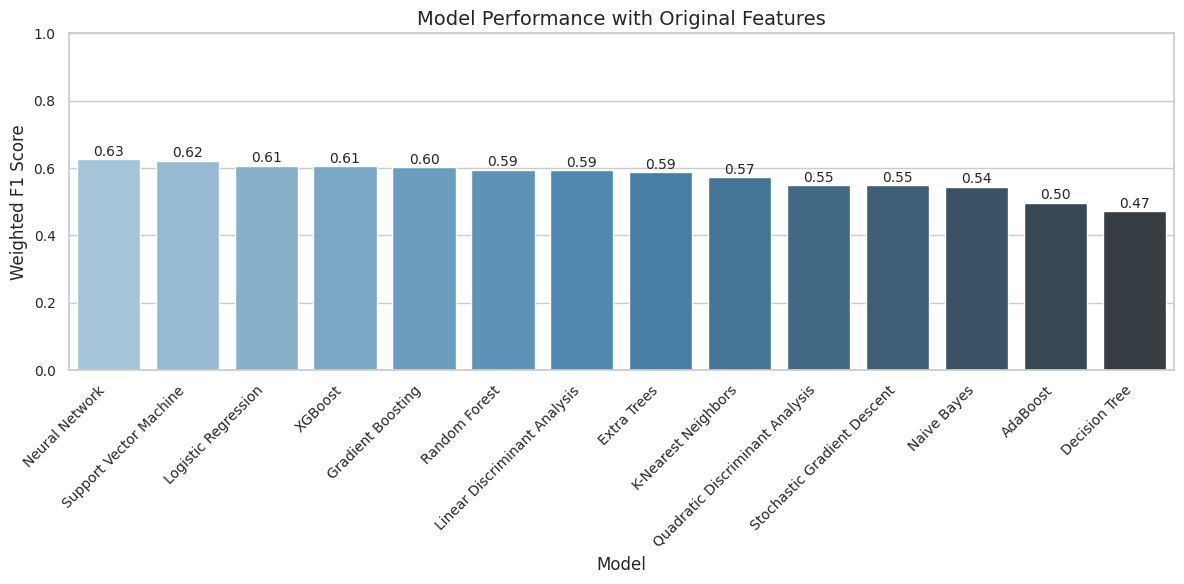

In [64]:
def plot_f1_scores(scores_dict, title, filename=None):
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")

    # Convert the scores_dict to a DataFrame and sort by F1 Score
    scores_df = pd.DataFrame(list(scores_dict.items()), columns=['Model', 'F1 Score'])
    scores_df = scores_df.sort_values('F1 Score', ascending=False)

    # Create a barplot
    ax = sns.barplot(x='Model', y='F1 Score', data=scores_df, palette='Blues_d')

    plt.ylabel('Weighted F1 Score', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(0, 1)

    # Add data labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.01,
                f'{height:.2f}', ha="center", fontsize=10)

    plt.tight_layout()

    # Save the plot if a filename is provided
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

# Plot original scores
plot_f1_scores(original_f1_scores, 'Model Performance with Original Features')

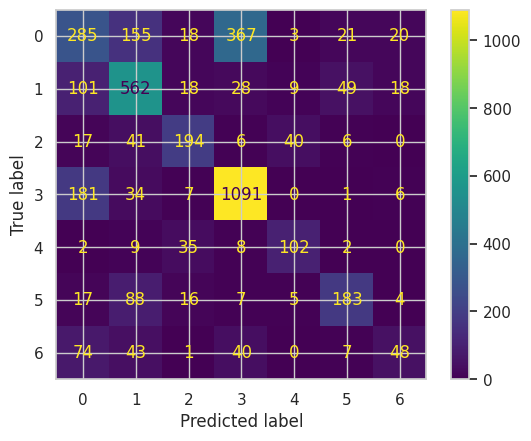

In [65]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Prepare the RNA features

In [66]:
# prepare data for training
features = rna_embedding.X
labels = None

In [67]:
predicted_RNA_CN = model.predict(features)

In [68]:
rna_embedding = anndata.AnnData(rna_embedding)
rna_embedding.obs = rna.obs
#  add the predicted CN labels to the RNA embedding
rna_embedding.obs['predicted_CN'] = pd.Categorical(predicted_RNA_CN)
# plot the RNA embedding with the predicted CN labels PCA
sc.tl.pca(rna_embedding)
# make the shape be the cell type
sc.pl.tsne(rna_embedding, color=['predicted_CN', 'Cluster'], title='Predicted CN labels on RNA-seq data')

KeyError: "Could not find 'tsne' or 'X_tsne' in .obsm"

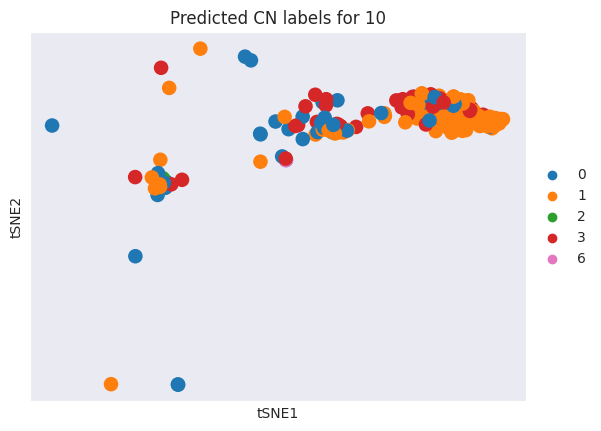

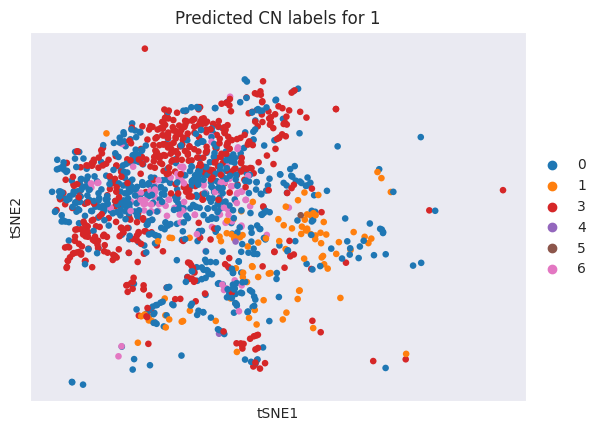

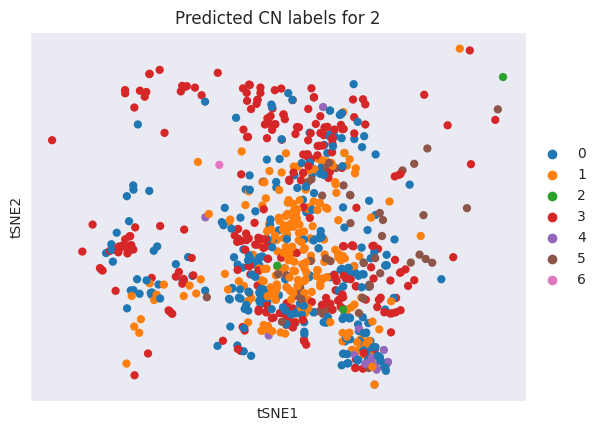

In [54]:
# 
cell_types = rna_embedding.obs['Cluster'].unique()
silhouette_score_per_cell_type = {}
davies_bouldin_score_per_cell_type = {}
calinski_harabasz_score_per_cell_type = {}
rna_embedding.obs['silhouette_score']  = [None]*rna_embedding.obs.shape[0]
rna_embedding.obs['davies_bouldin_score']  = [None]*rna_embedding.obs.shape[0]
rna_embedding.obs['calinski_harabasz_score']  = [None]*rna_embedding.obs.shape[0]
for curr_cell_type in cell_types:
    # get the scores for each cell type cluster
    curr_cell_type_indexes = rna_embedding.obs['Cluster'] == curr_cell_type
    curr_cell_type_data = rna_embedding[curr_cell_type_indexes].X
    curr_predicted_CN = rna_embedding.obs['predicted_CN'][curr_cell_type_indexes]
    
    silhouette_score_per_cell_type[curr_cell_type] = silhouette_score(curr_cell_type_data, curr_predicted_CN)
    davies_bouldin_score_per_cell_type[curr_cell_type] = -  davies_bouldin_score(curr_cell_type_data, curr_predicted_CN) # we want higer better
    calinski_harabasz_score_per_cell_type[curr_cell_type] = calinski_harabasz_score(curr_cell_type_data, curr_predicted_CN)
    
    rna_embedding.obs['silhouette_score'][curr_cell_type_indexes] = silhouette_score_per_cell_type[curr_cell_type]
    rna_embedding.obs['davies_bouldin_score'][curr_cell_type_indexes] = davies_bouldin_score_per_cell_type[curr_cell_type]
    rna_embedding.obs['calinski_harabasz_score'][curr_cell_type_indexes] = calinski_harabasz_score_per_cell_type[curr_cell_type]

# normalize all scores between 0 and 1 and means them to one final score using sklearn.preprocessing.MinMaxScaler:
scaler = MinMaxScaler()
rna_embedding.obs['norm_silhouette_score'] = scaler.fit_transform(rna_embedding.obs['silhouette_score'].values.reshape(-1, 1))
rna_embedding.obs['norm_davies_bouldin_score'] = scaler.fit_transform(rna_embedding.obs['davies_bouldin_score'].values.reshape(-1, 1))
rna_embedding.obs['norm_calinski_harabasz_score'] = scaler.fit_transform(rna_embedding.obs['calinski_harabasz_score'].values.reshape(-1, 1))
 
# mean all score to final score
rna_embedding.obs['final_score'] = (rna_embedding.obs['norm_silhouette_score'] + rna_embedding.obs['norm_davies_bouldin_score'] + rna_embedding.obs['norm_calinski_harabasz_score'])/3
sns.barplot(x='Cluster', y='final_score', data=rna_embedding.obs)
plt.title('Final Clustering Score on RNA-seq data')
plt.show()



NameError: name 'rna_embedding' is not defined

KeyboardInterrupt: 

In [50]:
# plot the RNA embedding with the silhouette score as color with jet cmap
sc.pl.tsne(rna_embedding, color='Cluster', title='cell types')
sc.pl.tsne(rna_embedding, cmap='plasma',color=['silhouette_score','davies_bouldin_score','calinski_harabasz_score'])
sc.pl.tsne(rna_embedding, cmap='plasma',color=['final_score'], title='final clustering Score on RNA-seq data')
# merge all score to one when higher means better so I will have to max(davies_bouldin_score) - davies_bouldin_score and normalize all scores
    
    


NameError: name 'rna_embedding' is not defined

In [51]:
best_sil_score_cell_types_index = np.argsort(list(silhouette_score_per_cell_type.values()))

truncated_cell_types = rna_embedding.obs['Cluster'].unique()[:3]
# take the best 3 cell types
np.argmax(silhouette_score_per_cell_type)
for curr_cell_type in truncated_cell_types:
    subset_data = rna_embedding[rna_embedding.obs['Cluster'] == curr_cell_type]
    sc.pl.tsne(subset_data, color='predicted_CN', title=f'Predicted CN labels for {curr_cell_type}')

NameError: name 'silhouette_score_per_cell_type' is not defined

In [52]:
num_clusters = len(np.unique(codex_embedding.obs['CN']))
gmm = GaussianMixture(n_components=num_clusters, random_state=0)
gmm_labels = gmm.fit_predict(rna_embedding.X)
ami_score = adjusted_mutual_info_score(rna_embedding.obs['predicted_CN'], gmm_labels)
rna_embedding.obs['GMM'] = pd.Categorical(gmm_labels)
print('Adjusted Mutual Information Score:', ami_score)

NameError: name 'codex_embedding' is not defined

In [53]:
# plot the RNA embedding with the HDBSCAN labels vs the predicted CN labels
sc.pl.tsne(rna_embedding, color=['GMM', 'predicted_CN'], title='GMM vs Predicted CN labels on RNA-seq data')

NameError: name 'rna_embedding' is not defined

In [80]:

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)
clusterer.fit(rna_embedding.X)
hierarchy = clusterer.single_linkage_tree_.to_numpy()
num_clusters = len(np.unique(codex_embedding.obs['CN']))
selected_clusters = cut_tree(hierarchy, n_clusters=num_clusters).flatten()
rna_embedding.obs['HDBSCAN_Cut'] = pd.Categorical(selected_clusters)
# Check mutual information score between predicted CN labels and the cut HDBSCAN labels
ami_score = adjusted_mutual_info_score(rna_embedding.obs['predicted_CN'], rna_embedding.obs['HDBSCAN_Cut'])
print('Adjusted Mutual Information Score:', ami_score)

Adjusted Mutual Information Score: -0.0003301123280076968


In [ ]:
# plot the RNA embedding with the HDBSCAN labels vs the predicted CN labels
sc.pl.pca(rna_embedding, color=['HDBSCAN_Cut', 'predicted_CN'], title='HDBSCAN vs Predicted CN labels on RNA-seq data')